In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as o
import geotorch
import torchvision.transforms as t

from src.distributions import *
from src.loggers import TensorBoardLogger, WandbLogger
from src.solvers import OTSolver
from src.plotters import SimplePlotter, plot_samples
from src.utils import *
from src.costs import InnerGW_opt, InnerGW_const
from src.models.resnet import resnet18_d

from torchvision.datasets import MNIST
# from torchsummary import summary
from tqdm import tqdm

torch.cuda.set_device(2)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport", entity="_devourer_")

In [3]:
data_dim = (1, 32, 32)
p, q = np.prod(data_dim, dtype=int), 2
n_neurons = 128

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = resnet18_d(data_dim, q)

In [4]:
def plot_classes(source, mover, n_components=10, n_samples=256, show=True):
    fig = plt.figure()
    for cls in range(10):
        samples = source.sample_from_class((n_samples,), 0)
        with torch.no_grad():
            moved_samples = mover(samples.to(DEVICE))
        plot_samples(moved_samples.cpu())
    plt.tight_layout()
    if show: plt.show()
    return fig

def run_experiment(source, target, cost, n_iter,
                   plotter, logger=None, **kwargs):
    try:
        solver = OTSolver(deepcopy(critic), deepcopy(mover), cost=cost,
                          plotter=plotter, logger=logger, device=DEVICE,
                          **kwargs)
        solver.fit(source, target, n_iter)
        logger.log("classes", plot_classes(source, solver.mover), solver._global_step + n_iter, close=True)
    except KeyboardInterrupt:
        pass
    finally:
        if logger: logger.finish()
    return solver

def load_mnist(root, transform=None):
    dataset = MNIST(root, transform=transform, download=True)
    images, targets = [], []
    for image, target in tqdm(dataset):
        images.append(image)
        targets.append(target)
    return torch.stack(images), torch.tensor(targets)

In [5]:
n_components = 10
features, classes = load_mnist("../../data/",
                               transform=t.Compose([t.Pad(2), t.ToTensor()]))
source = TensorDatasetDistribution(features, classes)

U, s, V = torch.pca_lowrank(features.flatten(1), q)

100%|█████████████████████████████████████████████████████████████████| 60000/60000 [00:09<00:00, 6443.98it/s]


In [12]:
params = dict(
scales_std=[.1, .4],
lr=[2e-4, 2e-5],
n_opt_iter=[2, 10, 20],
n_inner_iter=[2, 10, 20])

In [13]:
from itertools import product

def product_dict(dct):
    for values in product(*dct.values()):
        yield dict(zip(dct.keys(), values))

<Figure size 432x288 with 0 Axes>

Output()

  0%|          | 0/5000 [00:00<?, ?it/s]

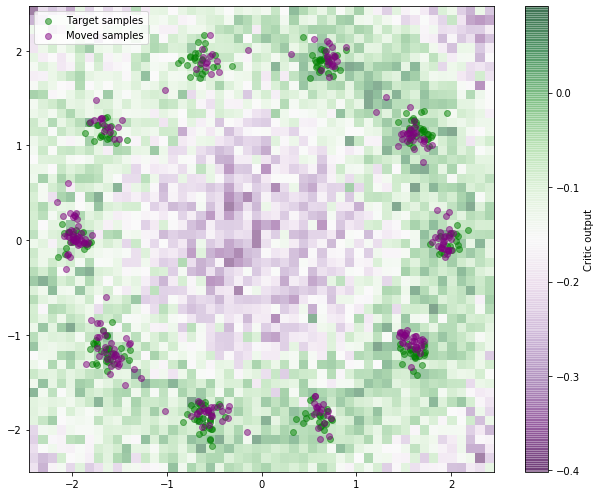

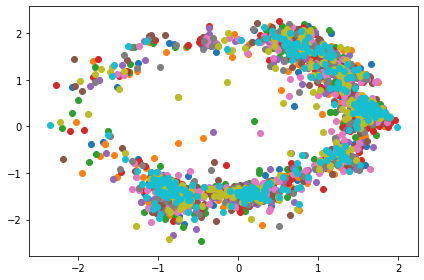

cost,▆▄▄█▅▅▂▁▁▃▁▂▂▂▁▂▁▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▆█▁▅▃▇▇▆▆▆▅▆▆▆▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
cost,0.01741
loss,0.02245


<Figure size 432x288 with 0 Axes>

Output()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
for param in product_dict(params):
    locs = 2 * uniform_circle(n_components)
    scales = param["scales_std"] * torch.ones(n_components, q)
    target = gaussian_mixture(locs, scales)
    
    wandb_logger.start()
    wandb_logger.log_hparams(param)
    
    solver = run_experiment(
        source, target,
        n_iter=int(1 / param["lr"]),
        n_samples=256,
        cost=InnerGW_opt(
            p, q, 
            optimizer=o.Adam,
            optimizer_params=dict(lr=param["lr"]),
            n_iter=param["n_opt_iter"],
            device=DEVICE
        ),
        plotter=SimplePlotter(
            source_dim=p,
            target_dim=q,
            pdf_params=dict(
                source_lims=None,
                target_lims=None,
                n_points=500
            ),
        show_progress=True
        ),
        logger=wandb_logger,
        n_inner_iter=param["n_inner_iter"],
        plot_interval=20,
        log_plot_interval=100,
        optimizer_params=dict(lr=param["lr"], weight_decay=1e-10),
    )
